# EmotionDetection_happy_or_sad

# Dependencies

In [2]:
import tensorflow as tf

2024-07-11 07:44:39.747754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 07:44:39.747852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 07:44:40.034436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [69]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import os
import numpy as np

In [4]:
import shutil
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [150]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [133]:
from tensorflow.keras.models import load_model

# GPU Config

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus, len(gpus)

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
  PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')],
 2)

In [11]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Init

In [12]:
data_dir = '/kaggle/input/emotiondetection-happy-or-sad/data'
base_dir = 'temp'

## Checking input dirs

In [13]:
file_counts = {}
for root, dirs, files in os.walk(data_dir):
        # Ignore the root directory itself
        if root == data_dir:
            continue

        # Get the directory name
        dir_name = os.path.basename(root)
        
        # Count the number of files in the current directory
        file_count = len(files)
        
        # Store the count in the dictionary
        file_counts[dir_name] = file_count
        print(f"Directory '{dir_name}' contains {file_count} files.")

Directory 'sad' contains 78 files.
Directory 'happy' contains 90 files.


## Reading one sample Img

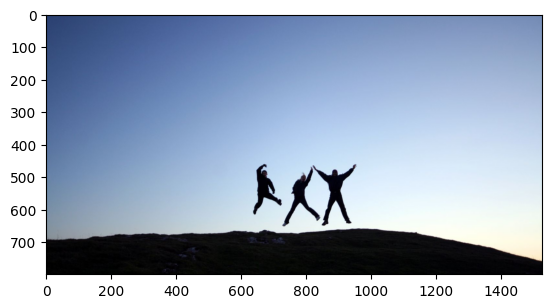

In [36]:
img = cv2.imread(os.path.join(data_dir, 'happy', 'jumping_for_joy_for_3_kinds_of_happy_people.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Split Data

In [15]:
dirs = [
    os.path.join(base_dir, 'train', 'happy'),
    os.path.join(base_dir, 'train', 'sad'),
    os.path.join(base_dir, 'test', 'happy'),
    os.path.join(base_dir, 'test', 'sad')
]
    
# Create each directory if it doesn't exist
for dir_path in dirs:
    os.makedirs(dir_path, exist_ok=True)

In [16]:
%ls temp
%ls temp/test
%ls temp/train

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


test/  train/
happy/  sad/
happy/  sad/


In [17]:
def count_files_in_directory(directory):
    file_count = sum([len(files) for r, d, files in os.walk(directory)])
    return file_count

In [18]:
def is_valid_image(file_name):
    return file_name.lower().endswith(('.jpg', '.jpeg', '.png'))

def copy_images(data_dir, category, train_dest, test_dest, split_ratio=5):
    source_dir = os.path.join(data_dir, category)
    for index, element in enumerate(os.listdir(source_dir)):
        if is_valid_image(element):
            img_path = os.path.join(source_dir, element)
            img = cv2.imread(img_path)
            if img is None:
                continue  # Skip if the image cannot be read
            if (index + 1) % split_ratio == 0:
                dest_path = os.path.join(test_dest, category, element)
            else:
                dest_path = os.path.join(train_dest, category, element)
            cv2.imwrite(dest_path, img)

In [19]:
categories = ['sad', 'happy']
for category in categories:
    copy_images(data_dir, category, os.path.join(base_dir, 'train'), os.path.join(base_dir, 'test'))

In [20]:
for root, dirs, files in os.walk(base_dir):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
            print(f"Directory '{os.path.join(root, dir_name)}' contains {file_count} files.")

Directory 'temp/train' contains 0 files.
Directory 'temp/test' contains 0 files.
Directory 'temp/train/happy' contains 72 files.
Directory 'temp/train/sad' contains 62 files.
Directory 'temp/test/happy' contains 18 files.
Directory 'temp/test/sad' contains 15 files.


In [21]:
# In case of emergency, remove dirs
# %rm -rf temp

## Load Dataset

In [139]:
def preprocess(image, label):
    """
    Scale the image pixels to the range [0, 1].
    """
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [203]:
def load_dataset(data_path, image_size, batch_size, subset, validation_split=None, seed=None):
    if subset:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=data_path,
            labels='inferred',
            label_mode='int',
            batch_size=batch_size,
            image_size=image_size,
            shuffle=True,
            seed=seed,
            validation_split=validation_split,
            subset=subset,
        )
    else:
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=data_path,
            labels='inferred',
            label_mode='int',
            batch_size=batch_size,
            image_size=image_size,
            shuffle=True,
            seed=seed
        )
    
    return dataset

In [204]:
height, width = 256, 256
batch_size = 64
image_size = (height, width)
seed = 30

train_data_path = 'temp/train'
test_data_path = 'temp/test'

trainData = load_dataset(
    data_path=train_data_path,
    image_size=image_size,
    batch_size=batch_size,
    subset='training',
    validation_split=0.2,
    seed=seed
)

valData = load_dataset(
    data_path=train_data_path,
    image_size=image_size,
    batch_size=batch_size,
    subset='validation',
    validation_split=0.2,
    seed=seed
)

testData = load_dataset(
    data_path=test_data_path,
    image_size=image_size,
    batch_size=batch_size,
    subset=None,
    seed=seed
)

Found 134 files belonging to 2 classes.
Using 108 files for training.
Found 134 files belonging to 2 classes.
Using 26 files for validation.
Found 33 files belonging to 2 classes.


## Build deep learning model

In [205]:
model = Sequential([
    # First Convolutional Layer
    # 16 filters, 3x3 kernel, stride of (1,1), ReLU activation, input shape 256x256x3
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu', input_shape=(256, 256, 3)), 
    
    # First Max Pooling Layer
    # Reduces spatial dimensions by a factor of 2 (default pool size is (2, 2))
    MaxPooling2D(),  
    
    # Second Convolutional Layer
    # 32 filters, 3x3 kernel, stride of (1,1), ReLU activation
    Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),  
    
    # Second Max Pooling Layer
    # Again, reduces spatial dimensions by a factor of 2
    MaxPooling2D(),  
    
    # Third Convolutional Layer
    # 16 filters, 3x3 kernel, stride of (1,1), ReLU activation
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu'),  
    
    # Third Max Pooling Layer
    # Reduces spatial dimensions by a factor of 2
    MaxPooling2D(),  
    
    # Flatten Layer
    # Flattens the 3D output to 1D for the Dense layers
    Flatten(),  
    
    # First Dense (Fully Connected) Layer
    # 256 units, ReLU activation
    Dense(256, activation='relu'),  
    
    # Second Dense (Fully Connected) Layer
    # 1 unit, sigmoid activation (unusual, but might be for specific use cases)
    Dense(1, activation='sigmoid')  
])

In [206]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [207]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [208]:
hist = model.fit(
    trainData,
    epochs=25,  # You can set a higher number of epochs since early stopping will take care of stopping early if needed
    validation_data=valData
)

Epoch 1/25
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.4531 - loss: 17.1282

W0000 00:00:1720689126.507656     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.4580 - loss: 119.3818

W0000 00:00:1720689127.395318     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4597 - loss: 153.4663 - val_accuracy: 0.6154 - val_loss: 200.0641
Epoch 2/25


W0000 00:00:1720689127.967579     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 0.5176 - loss: 170.0389 - val_accuracy: 0.3846 - val_loss: 21.5129
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.4824 - loss: 17.4397 - val_accuracy: 0.3846 - val_loss: 10.7689
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step - accuracy: 0.5565 - loss: 4.6057 - val_accuracy: 0.6154 - val_loss: 2.0097
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.7305 - loss: 1.3068 - val_accuracy: 0.7308 - val_loss: 0.9357
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8036 - loss: 0.4321 - val_accuracy: 0.5000 - val_loss: 3.4531
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.7178 - loss: 1.2744 - val_accuracy: 0.5769 - val_loss: 1.1993
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.9369 - loss: 0.1448 - val_accuracy: 0.5385 - val_loss: 0.8997
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.9431 - loss: 0.1203 - val_accuracy: 0.5000 - val_loss: 1.133

In [213]:
hist.history

{'accuracy': [0.46296295523643494,
  0.5185185074806213,
  0.48148149251937866,
  0.5925925970077515,
  0.7129629850387573,
  0.8148148059844971,
  0.7407407164573669,
  0.9444444179534912,
  0.9537037014961243,
  0.9722222089767456,
  0.9814814925193787,
  0.9907407164573669,
  0.9907407164573669,
  0.9907407164573669,
  0.9907407164573669,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [221.63531494140625,
  147.1113739013672,
  16.85137176513672,
  3.9126827716827393,
  1.3430907726287842,
  0.39569833874702454,
  1.085332989692688,
  0.13951781392097473,
  0.11255159229040146,
  0.09578237682580948,
  0.05791427567601204,
  0.025749612599611282,
  0.013427484780550003,
  0.009856290183961391,
  0.007176968734711409,
  0.0056737191043794155,
  0.004065998364239931,
  0.0019281178247183561,
  0.0009161423076875508,
  0.0005662165931425989,
  0.0001886152458610013,
  5.988310294924304e-05,
  1.9707151295733638e-05,
  4.9722925723472144e-06,
  2.5158035

# Plot Performance

In [189]:
def plot_performance(history, feature):
    fig = plt.figure()
    plt.plot(history.history[feature], color='teal', label=feature)
    plt.plot(history.history['val_' + feature], color='orange', label='val_' + feature)
    fig.suptitle(feature, fontsize=20)
    plt.legend(loc='best')
    plt.show()

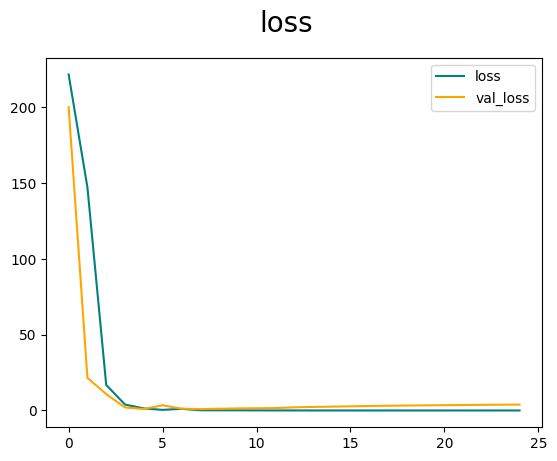

In [209]:
plot_performance(hist, 'loss')

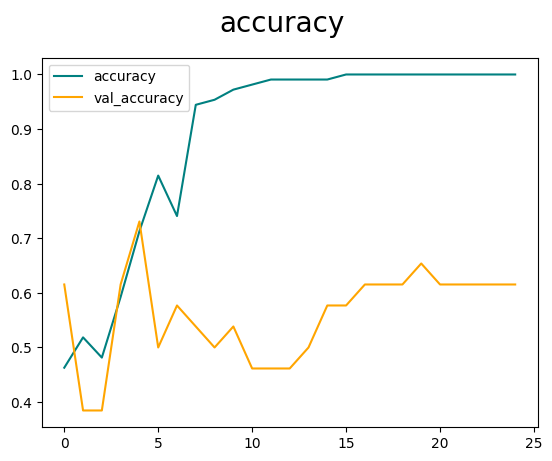

In [210]:
plot_performance(hist, 'accuracy')

# Evaluate Performance

## Evaluate

In [56]:
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [211]:
for batch in testData.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


In [212]:
print(f"Precision : {prec.result()}")
print(f"Recall : {rec.result()}")
print(f"Accuracy : {acc.result()}")

Precision : 0.5494505763053894
Recall : 0.5128205418586731
Accuracy : 0.5874125957489014


# Test

In [62]:
path_of_test_image = 'temp/test/sad/screen-shot-2014-07-31-at-6-09-12-pm.png'

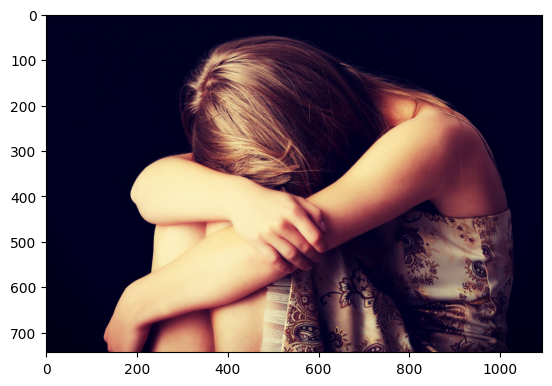

In [64]:
img = cv2.imread(path_of_test_image)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Reshape image

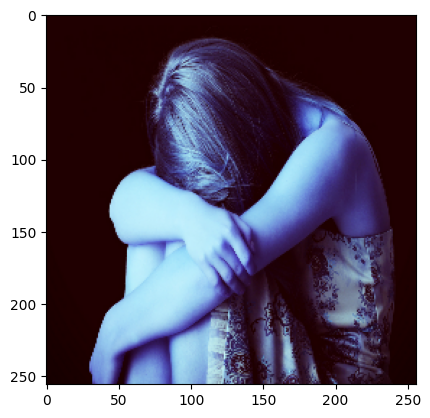

In [66]:
resize = tf.image.resize(img, image_size)
plt.imshow(resize.numpy().astype(int))
plt.show()

In [215]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [73]:
def give_prediction(yhat):
    if yhat > 0.5:
        print("Sad image")
    else:
        print("Happy image")

In [216]:
give_prediction(yhat)

Sad image


## Save the model

In [134]:
%mkdir models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [217]:
model.save(os.path.join('models', 'emotion_classifier.h5'))

In [218]:
new_model = load_model(os.path.join('models', 'emotion_classifier.h5'))

In [221]:
give_prediction(new_model.predict(np.expand_dims(resize/255, 0)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sad image
